In [16]:
import netCDF4 as nc 
# miscellaneous operating system interfaces
import os

# visualizes the data
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

#processes the data
import numpy as np 
import pandas as pd

# helps visualize the data
import cartopy.crs as ccrs 
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.feature import BORDERS, COASTLINE


from matplotlib.colors import TwoSlopeNorm

import geopandas as gpd
from shapely.geometry import Point

from sklearn.decomposition import PCA

In [17]:
# LOAD DATA
file_path = '../Data/GRCTellus.JPL.200204_202411.GLO.RL06.3M.MSCNv04CRI.nc'
file_path = '../Data/JPL_Mascons.nc'

# Check if the file exists
if os.path.exists(file_path):
    mascons = nc.Dataset(file_path)
else:
    raise FileNotFoundError(f"File not found: {file_path}")

In [18]:
# try to reformat time into months
from datetime import datetime, timedelta

# Extract necessary variables
time_data = mascons.variables['time'][:]  # Time in days since 2002-01-01T00:00:00Z
lwe_thickness = mascons.variables['lwe_thickness'][:]  # Shape (239, 360, 720)
only_land_mask = np.array(mascons["lwe_thickness"]) * np.array(mascons["land_mask"]) # Shape (360, 720)
print(only_land_mask.shape)

# Step 1: Convert time to datetime
start_date = datetime(2002, 1, 1)
time_dates = np.array([start_date + timedelta(days=int(t)) for t in time_data])

# Step 2: Create a pandas DataFrame for grouping
time_df = pd.DataFrame({'time': time_dates})
time_df['year_month'] = time_df['time'].dt.to_period('M')  # Convert to 'YYYY-MM' format for grouping

/tmp/ipykernel_1354/696913628.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  only_land_mask = np.array(mascons["lwe_thickness"]) * np.array(mascons["land_mask"]) # Shape (360, 720)


(239, 360, 720)


In [19]:
def plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index=None):
    """
    Plots the LWE thickness for a specific region defined by center latitude, center longitude,
    width, and height in degrees, applying a landmask.

    Parameters:
        center_lat (float): Center latitude of the region.
        center_lon (float): Center longitude of the region.
        width (float): Width of the region in degrees.
        height (float): Height of the region in degrees.
        time_index (int, optional): Index of the time step to plot. If None, defaults to the global variable i.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    # Adjust center_lon to match the dataset's range (0 to 360)
    if center_lon < 0:
        center_lon += 360

    # Calculate the bounds of the region
    lat_min = max(center_lat - height / 2, 45) #45 N as a treshold to get the right frame for canada
    lat_max = min(center_lat + height / 2, 70) #70 N as a threshold to get the right frame to not get nunavut
    lon_min = center_lon - width / 2
    lon_max = center_lon + width / 2

    # Filter the latitude and longitude indices
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

    # Check if indices are valid
    if len(lat_indices) == 0 or len(lon_indices) == 0:
        print("No data available for the specified region.")
        return

    # Extract the subset of data
    subset_lat = lat[lat_indices]
    subset_lon = lon[lon_indices]
    time_idx = time_index if time_index is not None else i
    subset_lwe_thickness = only_land_mask[time_idx, lat_indices[:, None], lon_indices] #changed this to only_land_mask could be also lwe_thickness

    # Check if subset_lwe_thickness is valid
    if subset_lwe_thickness.size == 0:
        print("No LWE thickness data available for the specified region.")
        return

    # Create a figure and axis with a Cartopy projection
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Define a normalization that centers the colorbar at 0
    data_min = subset_lwe_thickness.min()
    data_max = subset_lwe_thickness.max()
    data_min=-data_max
    if data_min < 0 and data_max > 0:
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0, vmax=data_max)
    else:
        norm = plt.Normalize(vmin=data_min, vmax=data_max)

    # Plot the lwe_thickness for the specified time step with the defined normalization
    lwe_plot = ax.pcolormesh(subset_lon, subset_lat, subset_lwe_thickness, 
                             cmap='seismic', norm=norm, transform=ccrs.PlateCarree())

    # Add coastlines, borders, and gridlines
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.gridlines(draw_labels=True)

    # Add a colorbar
    cbar = plt.colorbar(lwe_plot, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Liquid Water Equivalent Thickness')

    # Set the colorbar ticks and range
    #cbar.set_ticks(np.linspace(data_min, data_max, num=5))  # 5 evenly spaced ticks
    #cbar.ax.tick_params(labelsize=10)  # Adjust tick label size

    # Set the title
    ax.set_title(f'LWE Thickness for Month {time_idx + 1} in Region ({center_lat}, {center_lon})')
    
    return fig, data_min, data_max



data_min -237.644336204148
data_max 237.644336204148


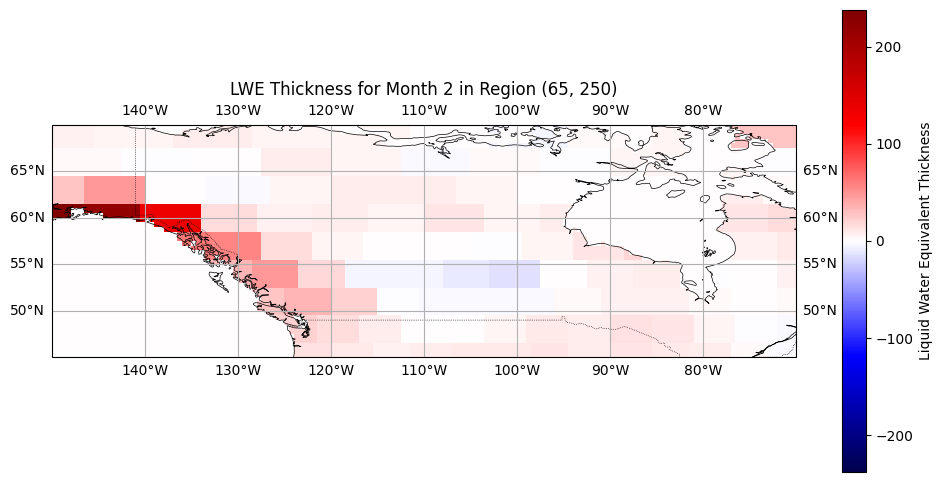

In [20]:
# Plotting the LWE thickness with landmask for canada
# Set the right rectangle parameters for canada
center_lat = 65
center_lon = -110
width = 80
height = 40
time_index = 1

lat = mascons.variables['lat'][:]
lon = mascons.variables['lon'][:]
lwe_thickness = mascons.variables['lwe_thickness'][:]

fig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)
print("data_min", data_min)
print("data_max", data_max)
# Show the plot
plt.show()

#### Starting with the EOF of Canada

- To do isch GAP handling

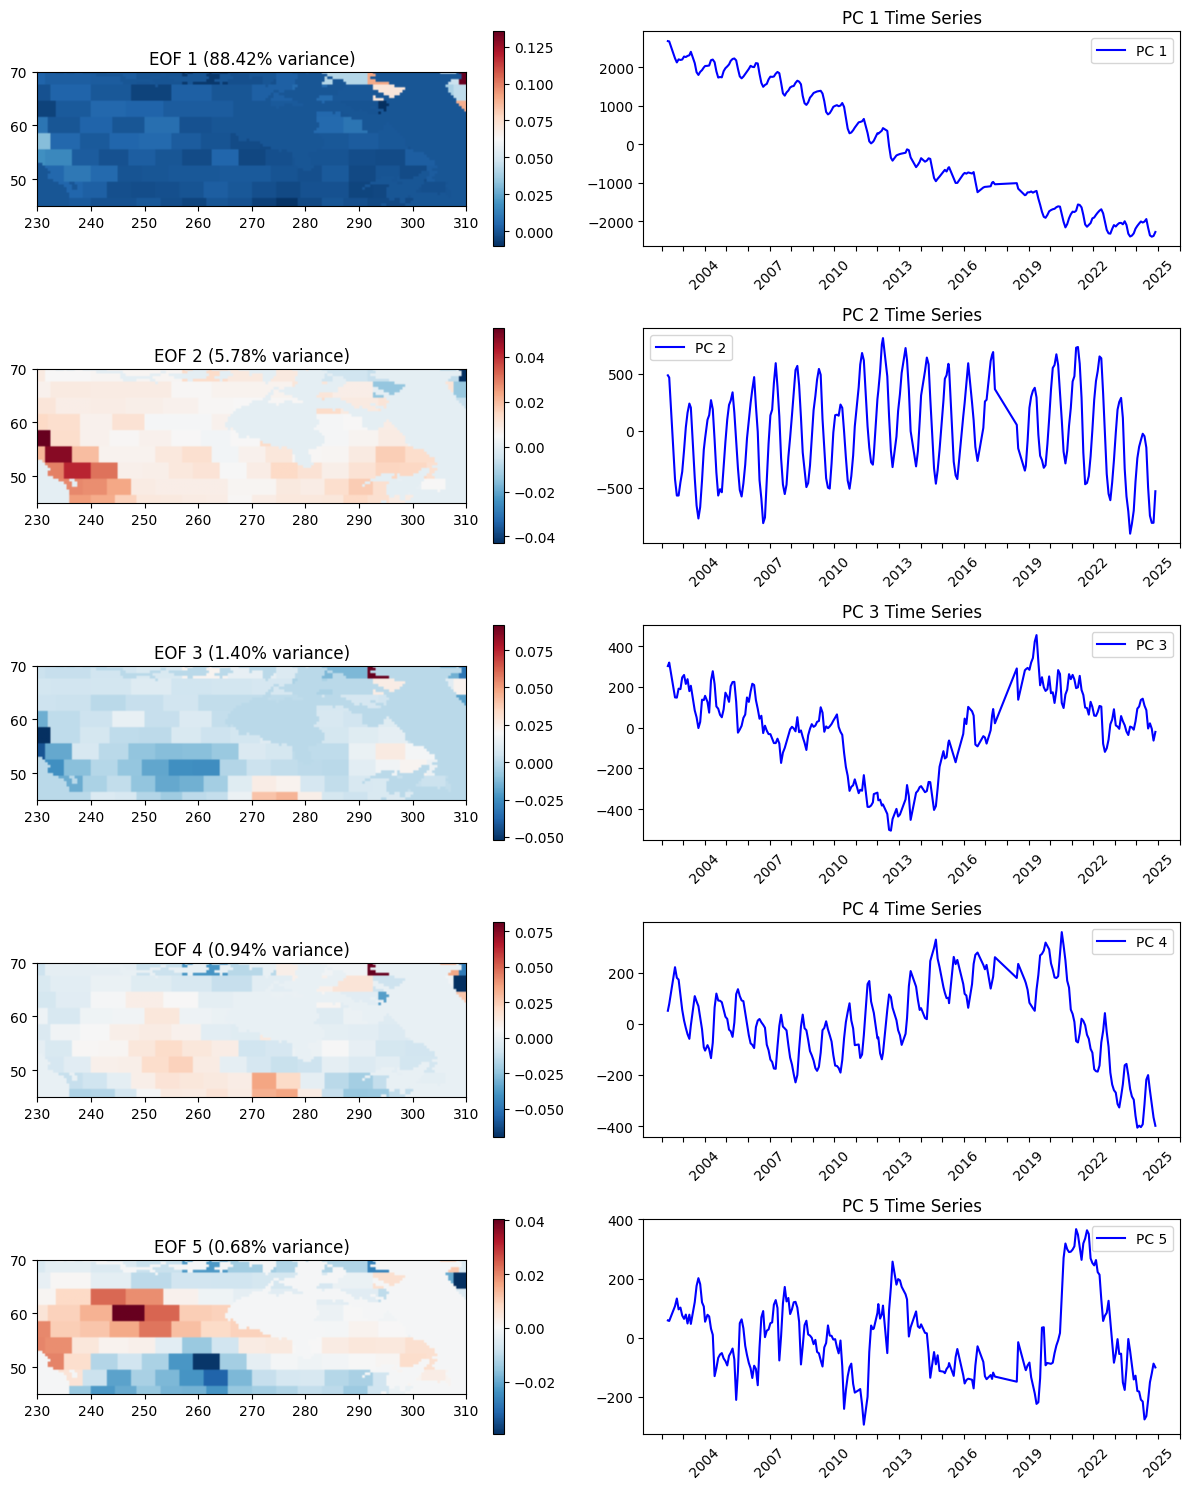

In [21]:
# Define the region of interest
center_lat = 60
center_lon = -90
width = 80
height = 40

# Adjust center_lon to match the dataset's range (0 to 360)
if center_lon < 0:
    center_lon += 360

# Calculate the bounds of the region
lat_min = max(center_lat - height / 2, 45)  # Ensure latitude is not below 45°N
lat_max = min(center_lat + height / 2, 70)  # Ensure latitude is not above 70°N
lon_min = center_lon - width / 2
lon_max = center_lon + width / 2

# Filter the latitude and longitude indices
lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

# Check if indices are valid
if len(lat_indices) == 0 or len(lon_indices) == 0:
    raise ValueError("No data available for the specified region.")

# Extract the subset of data
subset_lat = lat[lat_indices]
subset_lon = lon[lon_indices]
subset_data = only_land_mask[:, lat_indices[:, None], lon_indices]  # Shape: (time, lat, lon)

# Flatten spatial dimensions for PCA
num_time_steps = subset_data.shape[0]
num_lat = len(lat_indices)
num_lon = len(lon_indices)
reshape_data = subset_data.reshape(num_time_steps, num_lat * num_lon)

# Remove time mean to compute anomalies (centering the data)
column_time_mean = np.mean(reshape_data, axis=0, keepdims=True)
data_centered = reshape_data - column_time_mean

# Perform PCA
pca = PCA(n_components=5)
pca.fit(data_centered)
transformed_data = pca.transform(data_centered)
explained_variance = pca.explained_variance_ratio_

# Visualize the EOFs and their time series
fig, axes = plt.subplots(5, 2, figsize=(12, 15))  # Adjust as needed
for i in range(5):  # Plot first 5 EOFs and their time series
    # EOF spatial pattern
    eof_pattern = pca.components_[i].reshape(num_lat, num_lon)
    im = axes[i, 0].imshow(eof_pattern, cmap='RdBu_r', origin='lower',
                           extent=[lon_min, lon_max, lat_min, lat_max])
    axes[i, 0].set_title(f'EOF {i+1} ({explained_variance[i]*100:.2f}% variance)')
    fig.colorbar(im, ax=axes[i, 0])

    # Principal component time series
    axes[i, 1].plot(time_dates, transformed_data[:, i], label=f'PC {i+1}', color='b')  # Use time_dates for x-axis
    axes[i, 1].set_title(f'PC {i+1} Time Series')
    axes[i, 1].legend()

    # Set ticks every year
    axes[i, 1].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year

    # Format labels to show the year only every 3 years
    def custom_year_formatter(x, pos):
        year = mdates.num2date(x).year
        return str(year) if year % 3 == 0 else ''  # Show year only if divisible by 3

    axes[i, 1].xaxis.set_major_formatter(FuncFormatter(custom_year_formatter))

    # Rotate the tick labels for better readability
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
def Convert_2002_2_DMJ(days, unit=mascons['time'].units):
    """
    Convert days since 2002-04-01 to date-month-year format.
    
    Parameters:
    -----------
    days : array-like
        Days since 2002-04-01
    unit : str
        Unit of the time, e.g. 'days', 'months', 'years'
    
    Returns:
    --------
    date : array-like
        Date in date-month-year format
    """
    
    # Convert days to datetime64
    date = nc.num2date(days, unit, only_use_cftime_datetimes=False, only_use_python_datetimes=False)

    if isinstance(date, np.ndarray):
        date = [datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in date]
    else:
        date = datetime(date.year, date.month, date.day, date.hour, date.minute, date.second)


    return date

In [22]:
def gap_detection(timestamps: np.array) -> np.array:
    """
    Detect missing timestamps in a time series.
    Parameters:
    -----------
    timestamps : array-like
        Timestamps of the data  
    
    Returns:
    missing timestamps"""

    # Convert numeric timestamps to datetime objects
    dates = Convert_2002_2_DMJ(timestamps)
    dates = [pd.to_datetime(d.strftime('%Y-%m')) for d in dates]
    dates = pd.DatetimeIndex(dates)
    
    min_date = dates.min()
    max_date = dates.max()
    all_dates = pd.date_range(start=min_date, end=max_date, freq='M')
    #transform all dates to the Y%-M% format
    all_dates = [pd.to_datetime(d.strftime('%Y-%m')) for d in all_dates]
    missing_dates = np.setdiff1d(all_dates, dates)


    return missing_dates

In [25]:
# %% IMPORTS FOR INTERPOLATION
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# %% ==== GAP DETECTION and INTERPOLATION ====

# 1. Identify Missing Dates more directly using pandas
print("Original number of time steps:", len(time_dates))

# Convert to pandas Series and then to monthly periods
time_periods = pd.Series(time_dates).dt.to_period('M')
print(f"Length after converting to monthly periods: {len(time_periods)}") # Should still be 239

# Find unique periods
unique_time_periods = time_periods.unique()
print(f"Length after finding unique monthly periods: {len(unique_time_periods)}") # Should be 237 if duplicates exist


if len(time_periods) != len(unique_time_periods):
    duplicated_months = time_periods[time_periods.duplicated(keep=False)].sort_values()
    print("\nMonths appearing more than once in time_dates:")
    print(duplicated_months.value_counts())
else:
    print("\nNo duplicate months found in time_dates.")

# Create a Series from the original dates for easier manipulation
original_dates_series = pd.Series(time_dates).dt.to_period('M').unique()
original_dates_dtindex = pd.PeriodIndex(original_dates_series, freq='M').to_timestamp()

# Create the full expected monthly date range
full_date_range = pd.date_range(start=original_dates_dtindex.min(),
                                end=original_dates_dtindex.max(),
                                freq='MS') # 'MS' for Month Start frequency

# Find the missing dates
missing_dates = full_date_range.difference(original_dates_dtindex)

print(f"Identified {len(missing_dates)} missing months.")
# print("Missing dates:", missing_dates) # Uncomment to see the list

# 2. Prepare Principal Components for Interpolation
# 'transformed_data' contains the PCs (shape: num_time_steps, n_components)
# 'time_dates' contains the corresponding dates for 'transformed_data'
pc_df = pd.DataFrame(data=transformed_data, index=original_dates_dtindex)
# print("PC DataFrame head:\n", pc_df.head())

# 3. Reindex to Full Time Range and Interpolate
# Reindex the DataFrame with the full date range, introducing NaNs for missing dates
pc_df_full = pc_df.reindex(full_date_range)

# Interpolate the missing values (NaNs) in the PC time series
# Common methods: 'linear', 'time', 'spline', 'polynomial'
# 'linear' is often a good start for monthly data.
pc_df_interpolated = pc_df_full.interpolate(method='linear', axis=0) # Interpolate along time axis

# Check if any NaNs remain (shouldn't if gaps are not at the very start/end)
# print("NaNs remaining after interpolation:", pc_df_interpolated.isnull().sum().sum())

# 4. Reconstruct Data for Missing Dates
# Select the interpolated PCs only for the originally missing dates
interpolated_pcs_for_missing = pc_df_interpolated.loc[missing_dates].values

# Use the inverse transform logic: reconstructed = (PCs @ EOFs) + mean
# EOFs are stored in pca.components_
# Mean was stored in column_time_mean
reconstructed_centered_missing = interpolated_pcs_for_missing @ pca.components_
reconstructed_data_missing = reconstructed_centered_missing + column_time_mean

# Reshape the reconstructed data back to spatial dimensions (lat, lon)
# The shape should be (num_missing_dates, num_lat, num_lon)
reconstructed_spatial_missing = reconstructed_data_missing.reshape(
    len(missing_dates), num_lat, num_lon
)
print("Shape of reconstructed data for missing months:", reconstructed_spatial_missing.shape)

# 5. Combine Original and Interpolated Data
# Create a dictionary to hold the combined data, keyed by timestamp
combined_data_dict = {}

# Add original data
original_data_spatial = data_centered.reshape(num_time_steps, num_lat, num_lon) + column_time_mean.reshape(1, num_lat, num_lon) # Reshape mean
for i, date in enumerate(original_dates_dtindex):
    combined_data_dict[date] = original_data_spatial[i, :, :]

# Add interpolated data
for i, date in enumerate(missing_dates):
    combined_data_dict[date] = reconstructed_spatial_missing[i, :, :]

# Sort the dictionary by date and extract data into a NumPy array
sorted_dates = sorted(combined_data_dict.keys())
combined_data_array = np.array([combined_data_dict[date] for date in sorted_dates])

# 'combined_data_array' now holds the LWE thickness for the region,
# with gaps filled, ordered chronologically according to 'sorted_dates'.
# Shape: (total_months, num_lat, num_lon)
print("Shape of final combined data array:", combined_data_array.shape)
print("Number of time steps in final array:", len(sorted_dates))

# %% ==== Verification Plot (Optional) ====
# Plot the first principal component: original vs interpolated

plt.figure(figsize=(15, 5))
plt.plot(pc_df.index, pc_df[0], 'o-', label='Original PC1', markersize=4)
plt.plot(pc_df_interpolated.index, pc_df_interpolated[0], '.-', label='Interpolated PC1', alpha=0.7, markersize=3, linestyle='--')
# Highlight the interpolated points specifically
plt.plot(missing_dates, pc_df_interpolated.loc[missing_dates, 0], 'rs', label='Filled Gaps (PC1)', markersize=5)

plt.title('Principal Component 1 Time Series (Original and Interpolated)')
plt.xlabel('Time')
plt.ylabel('PC1 Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# You can now use 'combined_data_array' and 'sorted_dates' for further analysis
# For example, recalculate the spatial average time series using the gap-filled data.
# spatial_average_filled = np.mean(combined_data_array, axis=(1, 2))
# plt.figure(figsize=(15, 5))
# plt.plot(sorted_dates, spatial_average_filled, label='Gap-Filled Spatial Average')
# plt.title('Spatially Averaged LWE Thickness (Gap-Filled)')
# plt.xlabel('Time')
# plt.ylabel('Average LWE Thickness (cm)')
# plt.legend()
# plt.grid(True)
# plt.show()

Original number of time steps: 239
Length after converting to monthly periods: 239
Length after finding unique monthly periods: 237

Months appearing more than once in time_dates:
2012-01    2
2015-04    2
Freq: M, Name: count, dtype: int64
Identified 35 missing months.


ValueError: Shape of passed values is (239, 5), indices imply (237, 5)

In [ ]:
from shapely.geometry import Point
canada_shape = gpd.read_file('../Data/lpr_000b21a_e/lpr_000b21a_e.shp')
canada_shape.plot()
canada_shape

# Filter out the PRNAME "Nunavut"
canada_shape_filtered = canada_shape[canada_shape['PRNAME'] != 'Nunavut']

# Plot the filtered shapefile
canada_shape_filtered.plot()
print(canada_shape_filtered)

DataSourceError: ../Data/lpr_000b21a_e/lpr_000b21a_e.shp: No such file or directory

In [ ]:
print(canada_shape_filtered)

   PRUID        DGUID                                             PRNAME  \
0     10  2021A000210  Newfoundland and Labrador / Terre-Neuve-et-Lab...   
1     11  2021A000211       Prince Edward Island / Île-du-Prince-Édouard   
2     12  2021A000212                      Nova Scotia / Nouvelle-Écosse   
3     13  2021A000213                  New Brunswick / Nouveau-Brunswick   
4     24  2021A000224                                    Quebec / Québec   
5     35  2021A000235                                            Ontario   
6     46  2021A000246                                           Manitoba   
7     47  2021A000247                                       Saskatchewan   
8     48  2021A000248                                            Alberta   
9     59  2021A000259            British Columbia / Colombie-Britannique   
10    60  2021A000260                                              Yukon   
11    61  2021A000261  Northwest Territories / Territoires du Nord-Ouest   

           

Note: Provinces that we should filter in: 
- British Colombia
- Alberta
- Manitoba
- Ontario
- Saskatchewan
- Quebec

all except Nunavut

In [ ]:
print(canada_geometry.bounds)
'''
# Create a mask for the region defined by the filtered shapefile
points = np.array([lon_grid.flatten(), lat_grid.flatten()]).T
canada_mask = np.array([canada_geometry.contains(Point(p)) for p in points]).reshape(lon_grid.shape)

# Apply the mask to the lwe_thickness data
masked_lwe_thickness = np.ma.masked_where(~canada_mask, lwe_thickness[time_index])

# Plot the LWE thickness for the specified region
fig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)
print("data_min", data_min)
print("data_max", data_max)
# Show the plot
plt.show()'''

(3689321.4628571793, 659305.0028571747, 9015750.722857185, 4748587.44285718)


'\n# Create a mask for the region defined by the filtered shapefile\npoints = np.array([lon_grid.flatten(), lat_grid.flatten()]).T\ncanada_mask = np.array([canada_geometry.contains(Point(p)) for p in points]).reshape(lon_grid.shape)\n\n# Apply the mask to the lwe_thickness data\nmasked_lwe_thickness = np.ma.masked_where(~canada_mask, lwe_thickness[time_index])\n\n# Plot the LWE thickness for the specified region\nfig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)\nprint("data_min", data_min)\nprint("data_max", data_max)\n# Show the plot\nplt.show()'